## Parte 3
## Rede neural auto-associativa
## (Autoencoder)

Modelo não supervisionado para aprendizado de características. Para estudar esse modelo utilizaremos o problema da reconstrução de imagens.

O espaço latente criado como resultado do treinamento pode ser utilizado como representação compacta dos dados, por exemplo para alimentar classificadores não-Deep Learning.

Serão utilizadas as bibliotecas Tensorflow e Keras

#### Moacir A. Ponti / Abril 2019

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
#from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


Importamos as bibliotecas necessárias. A primeira linha é para melhorar a compatibilidade entre python2 e python3. Depois importamos:
- a biblioteca tensorflow, a matplotlib para gerar gráficos 
- a biblioteca numpy com muitas funcoes para processamento vetorial
- a biblioteca keras, sendo importados pacotes com os dados que serão utilizados nesse notebook

### Base de dados

A seguir iremos carregar efetivamente os dados de treinamento e de testes, cada qual dividido nos dados de entrada $x$ (nesse caso imagens) sem os rótulos pois os auto-encoders são não-supervisionados

Comente e descomente as linhas conforme a base de dados

In [0]:
# carrega as imagens e rotulos de treinamento e teste, separando em 4 matrizes
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


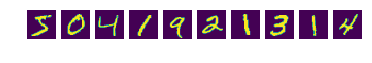

In [3]:
# visualizando algumas imagens de treinamento
n_imgs = 10
for im in np.arange(n_imgs):
  plt.subplot(1,n_imgs,im+1)
  plt.imshow(x_train[im], cmap="gray")
  plt.axis('off')

Agora iremos preprocessar a base de dados, capturando seu tamanho e reescalando os valores para o intervalo 0-1

Além disso a base de dados é reformatada - capturamos o formato pelo pacote "K" de forma a adequar se a imagem é armazenada no formato (linhas x colunas x canais) ou (canais x linhas x colunas)

In [0]:
# capturando o tamanho das imagens da base de dados por meio do 'shape' 
# dos arrays carregados
img_rows, img_cols = x_train.shape[1], x_train.shape[2]

# número de classes
#num_classes = len(np.unique(y_train))

# verifica se as imagens da base de dados tem um canal (i.e. em tons de cinza)
# ou mais do que um canal e se houver mais do que um canal entao armazena a
# quantidade de canais
gray = (len(x_train.shape) == 3)
if (not gray):
  n_channels = x_train.shape[3]
else:
  n_channels = 1 

# re-formatando as imagens de forma que sejam transformadas em 
# matrizes com canais (por exemplo quando as imagens sao RGB)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_rows, img_cols)
    input_shape = (n_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)
    input_shape = (img_rows, img_cols, n_channels)

In [5]:
# os pixels das imagens sao reescalados para melhor processamento
# em particular divide-se por 255 para que os valores fiquem entre 0 e 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print('Dataset size:')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Data size %d x %d' % (img_rows, img_cols))

Dataset size:
60000 train samples
10000 test samples
Data size 28 x 28


### Configuração do modelo 



In [6]:
input_img = Input(shape=(img_rows, img_cols,n_channels,))

# encoder
## conv.layers
x1 = Conv2D(16, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
x2 = Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu')(x1)
x2p = MaxPooling2D(pool_size=(2, 2))(x2)

## dense
x2f = Flatten()(x2p)
x2d = Dropout(0.25)(x2f)
# code
z = Dense(16, activation='relu')(x2d)

# decoder
x2f_hat = Dense(576, activation='relu')(z)
x2r_hat = Reshape((6, 6, 16))(x2f_hat)
x2p_hat = UpSampling2D((2,2))(x2r_hat)

x2_hat = Conv2DTranspose(16, kernel_size=(3,3), padding='valid', activation='relu')(x2p_hat)
x1_hat = Conv2DTranspose(1, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(x2_hat)

#x_hat = Dense(784, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x1_hat)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_1 (Dropout)  

Note como o modelo com camadas convolucionais possui menos parâmetros - esse fato foi um dos motivos de se aumentar a quantidade de camadas convolucionais permitindo a convergência do modelo.

### Compilação e treinamento do modelo
Agora iremos compilar o modelo, definindo:
- A função de custo: utilizamos a entropia cruzada categórica, ou seja, que utiliza rótulos
- O método de otimização:  utilizamos um método baseado no gradiente descendente (Adam) e definimos seus parâmetros como a taxa de aprendizado (*learning rate*) e *momentum*


In [0]:
autoencoder.compile(loss='binary_crossentropy', 
                    optimizer='adam')


Finalmente, treinamos o método pela função *fit*, que ajusta os parâmetros aos dados rotulados x_train, y_train e utilizando as configurações de:
- tamanho do *minibatch*, ou seja a quantidade de imagens a serem carregadas em cada iteracao do algoritmo de treinamento da rede neural
- número de épocas: em uma *época/epoch* o algoritmo utiliza todas as imagens do conjunto de treinamento (por exemplo, para a MNIST significa carregar 60 mil imagens e utilizá-las para treinar a rede)


Também informamos quais são os dados de validação. A opção *verbose* exibe os detalhes do processo de treinamento na tela

In [8]:
# tamanho do batch por iteracao
batch_size = 32

# número de épocas 
epochs = 7

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1988 - val_loss: 0.1595
Epoch 2/7
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1716 - val_loss: 0.1601
Epoch 3/7
60000/60000 [==============================] - 71s 1ms/step - loss: 0.1658 - val_loss: 0.1455
Epoch 4/7
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1628 - val_loss: 0.1495
Epoch 5/7
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1617 - val_loss: 0.1485
Epoch 6/7
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1519 - val_loss: 0.1360
Epoch 7/7
60000/60000 [==============================] - 70s 1ms/step - loss: 0.1481 - val_loss: 0.1304


### Avaliação do modelo
Com o modelo já treinado, podemos agora avaliar o seu desempenho, tanto no conjunto de treinamento quanto no conjunto de testes

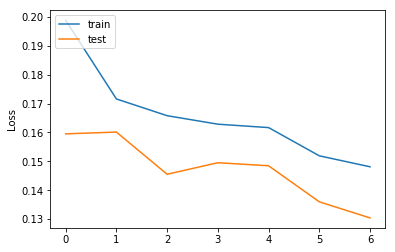

In [9]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Agora podemos também classificar todos os exemplos de teste e visualizar os resultados de acordo com os rótulos

In [0]:
# obtem as predicoes
decoded_imgs = autoencoder.predict(x_test)

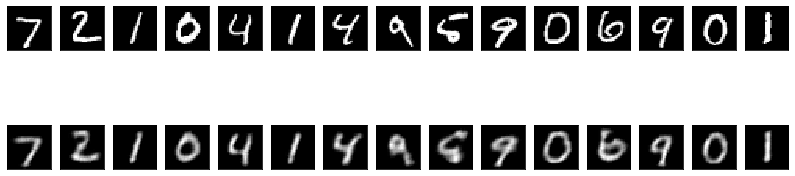

In [11]:
n=15
plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()    

In [0]:
met_m = autoencoder.evaluate(x_test, x_test, verbose=0)

In [13]:
print(met_m)

0.13042120637893675


In [0]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [16]:
code_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)
code_train = np.asarray(code_model.predict(x_train))
code_test  = np.asarray(code_model.predict(x_test))
print("Training data size = ", code_train.shape)
print("Testing data size = ", code_test.shape)

Training data size =  (60000, 16)
Testing data size =  (10000, 16)


In [17]:
print('Treinando SVM...')
clf = svm.LinearSVC(C=2)
clf.fit(code_train, y_train)

Treinando SVM...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [18]:
print('Calculando score...')
score = clf.score(code_test, y_test)
print('\nscore: ' + str(score))

Calculando score...

score: 0.8984


## Exercícios:


1.   Modifique a arquitetura do Autoencoder, reduzindo e adicionando camadas
2.   Adicione uma camada convolucional no encoder e no decoder
3.  Crie um *denoising* autoencoder, inserindo ruído na imagem antes da entrada e criando uma função de custo para comparar a imagem reconstruída com a imagem não ruidosa de entrada - para isso você deverá pesquisar mais sobre implementação de funções de custo no Keras

